In [50]:
import pandas as pd
import numpy as np
import os
from scipy import optimize
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Data curation

In [51]:
#  define the exponential function
def func(time,a,kobs):
    return a*(1-np.exp(-kobs*time))

In [52]:
file_path = './CCDi_data/Ratios/50_2/Di_50uM_Di_4GF_2uM_25degC_rep1.txt'


In [169]:
def file_to_data(file_path,trim=(0,-1)):
    
    # Define the regular expression pattern
    pattern = r'Di_(\d+)uM_Di_4GF_(\d+)uM_(\d+)degC_rep(\d+)'

    # Find all numbers in the string using regex
    match = re.findall(pattern, file_path)

    match = match[0]

    # Check if a match is found
    if match:
        # Extract numbers from groups
        conc_Di = int(match[0])
        conc_DiF = int(match[1])
        temp = int(match[2])
        rep = int(match[3])

        # Print the numbers
        print(f"The concentration of CC-Di was: {conc_Di}")
        print(f"The concentration of labelled CC-Di was: {conc_DiF}")
        print(f"The temperature was: {temp}°C")
        print(f"The is replicate number: {rep}")
        print(f"Reading file at: {file_path}")
        
        # Read raw data
        df = pd.read_csv(file_path,
                    delimiter='\t',
                    header=None,
                    skiprows=18)
        #  Add column headers
        df.columns=['t','F']
        df['temp']=temp
        df['concDi']=conc_Di
        df['concDiF']=conc_DiF
        df['rep']=rep
        df['filepath']=file_path

    else:
        print("No match found.")
        df = None
        
    if df.empty:
        print("No data")
    else:
        xdata=df['t']
        ydata=df['F']
        
        plt.figure(0,(6,5))
        plt.title(f"{conc_Di}uM CC-Di with {conc_DiF}uM CC-DiF,\nat {temp}°C, rep {rep},\nin PBS at pH 7.4",fontsize=8)
        plt.plot(xdata,ydata)
        plt.ylabel('Raw Fluorescence (A.U.)')
        plt.xlabel('Time (secs)')
        plt.axvline(xdata[trim[0]],c='orange')
        plt.axvline(xdata[len(xdata)+trim[1]],c='orange')
        plt.legend(labels=['Data'])
        
        figpath= file_path.replace('.txt','_trimmed_data.png')
        print(f"Saving plot to: {figpath}")

        plt.savefig(figpath)
    
        plt.show()
        
        
        
        df=df.iloc[trim[0]:trim[1],:]
        #normalise fluorescence
        df.loc[:, 'Fnrm'] = (df['F'] - df['F'].min()) / (df['F'].max() - df['F'].min())
        #normalise time such that the first time point is 0 seconds
        df.loc[:, 't0'] = df['t'] - df['t'].min()

        xdata=df['t0']
        ydata=df['Fnrm']

        popt, pcov = curve_fit(func, xdata, ydata,p0=[1,1])

        t = np.arange(0.0,max(xdata),0.001)
        new_value = func(t, popt[0],popt[1])
        val = func(xdata, popt[0],popt[1])

        rate = popt[1]
        half_life=(np.log(2)/popt[1])
        r2_fit = r2_score(ydata, val)


        residuals_fit = func(xdata, popt[0],popt[1])
        residuals = ydata-residuals_fit

        plt.clf()
        
        # Set up the figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot the data and fit on the main plot (ax1)
        ax1.set_ylabel('Normalised Fluorescence (A.U.)')
        ax1.legend()
        ax1.set_title(f"{conc_Di}uM CC-Di with {conc_DiF}uM CC-DiF,\nat {temp}°C, rep {rep},\nin PBS at pH 7.4",fontsize=8)
        ax1.plot(xdata,ydata)
        ax1.plot(t,new_value)
        ax1.legend(labels=['Data','Fit'])
        fit_data_string = (fr"rate = {np.round(rate, 6)} $s^{{-1}}$" + "\n" +
                   fr"half life = {np.round(half_life, 1)} $s^{{-1}}$" + "\n" +
                   fr"$R^2$ fit = {np.round(r2_fit, 3)}")
        ax1.annotate(fit_data_string, xy=(0.7,0.05), xycoords='axes fraction')

        data = {'temp':temp,
                'concDi':conc_Di,
                'concDiF':conc_DiF,
                'rep':rep,
                'filepath':file_path,
                'rate':rate,
                'halflife':half_life,
                'r2':r2_fit,
                'rmv from start':trim[0],
                'rmv from end':trim[1],
        }
        
        ax2.plot(xdata,residuals)
        ax2.axhline(0, color='gray', linestyle='--')  # Line at zero for reference
        ax2.set_ylabel('Residuals (A.U.)')
        ax2.set_xlabel('Time (secs)')        
        figpath= file_path.replace('txt','png')
        
        print(f"Saving plot to: {figpath}")
        data['figpath']=figpath

        plt.savefig(figpath)
    
        plt.show()
        
        return df, data
            
    
    

In [170]:

def find_txt_files(folder):
    txt_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                txt_files.append(os.path.join(root, file))
    return txt_files

folder_path = "./CCDi_data/Ratios_const_labelled/"
txt_files = find_txt_files(folder_path)

In [171]:
txt_files

['./CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/100_2/Di_100uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/100_2/Di_100uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/100_2/Di_100uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_labelled/30_2/Di_30uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_labelled/30_2/Di_30uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/30_2/Di_30uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/0_2/CCDi_0uM_CCDi4GF_2uM_PBS_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/20_2/Di_20uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/20_2/Di_20uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/20_2/Di_20u

The concentration of CC-Di was: 200
The concentration of labelled CC-Di was: 2
The temperature was: 25°C
The is replicate number: 2
Reading file at: ./CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.txt
Saving plot to: ./CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2_trimmed_data.png


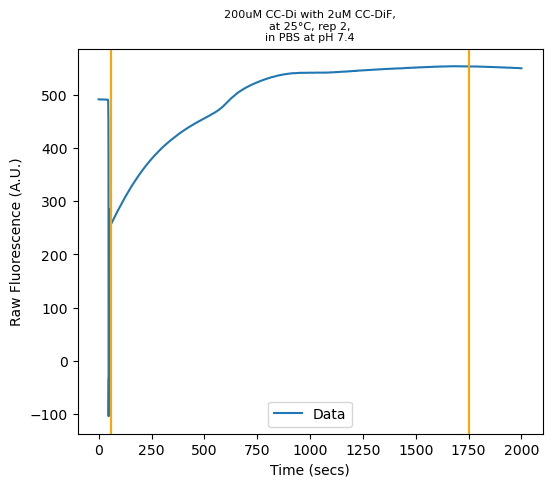

/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_91000/2042243895.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


Saving plot to: ./CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.png


<Figure size 640x480 with 0 Axes>

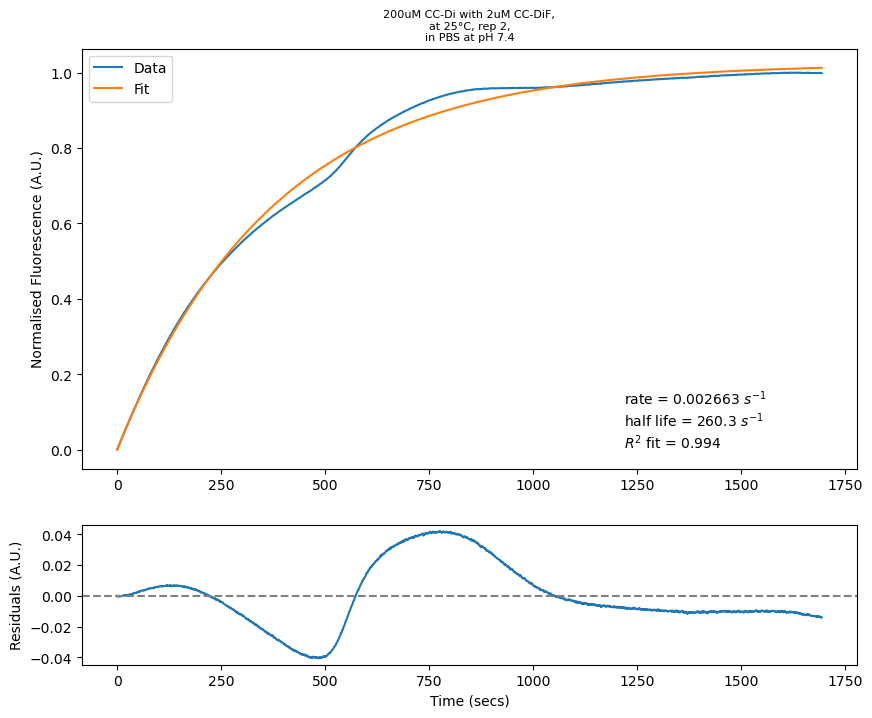

In [67]:
df, data= file_to_data(txt_files[0],
            trim=(113,-500))

In [68]:
master_df = df.copy()

master_dict = [data.copy()]

In [172]:
txt_files

['./CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/200_2/Di_200uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/100_2/Di_100uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/100_2/Di_100uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/100_2/Di_100uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_labelled/30_2/Di_30uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_labelled/30_2/Di_30uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/30_2/Di_30uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/0_2/CCDi_0uM_CCDi4GF_2uM_PBS_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/20_2/Di_20uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_labelled/20_2/Di_20uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_labelled/20_2/Di_20u

In [174]:
txt_files[3]

'./CCDi_data/Ratios_const_labelled/100_2/Di_100uM_Di_4GF_2uM_25degC_rep1.txt'

The concentration of CC-Di was: 1
The concentration of labelled CC-Di was: 2
The temperature was: 25°C
The is replicate number: 2
Reading file at: ./CCDi_data/Ratios_const_labelled/1_2/Di_1uM_Di_4GF_2uM_25degC_rep2.txt
Saving plot to: ./CCDi_data/Ratios_const_labelled/1_2/Di_1uM_Di_4GF_2uM_25degC_rep2_trimmed_data.png


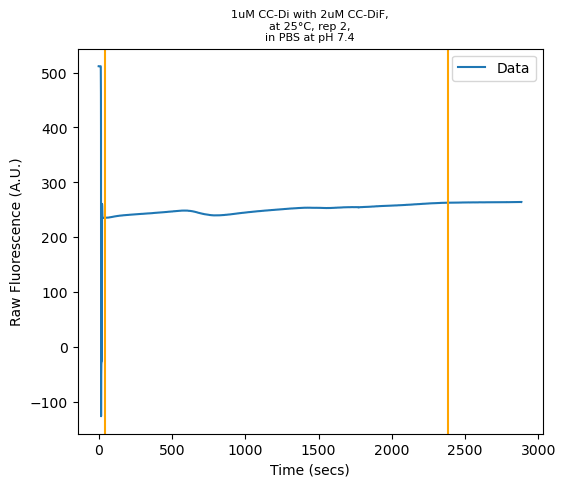

/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_91000/2042243895.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


Saving plot to: ./CCDi_data/Ratios_const_labelled/1_2/Di_1uM_Di_4GF_2uM_25degC_rep2.png


<Figure size 640x480 with 0 Axes>

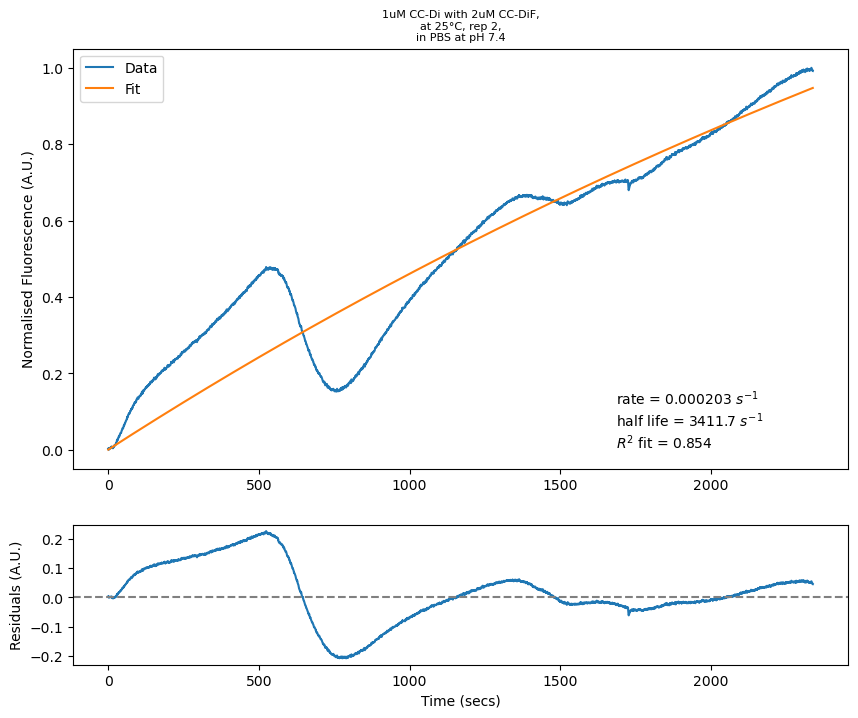

In [98]:
df, data= file_to_data(txt_files[3],
            trim=(90,-1000))
master_df = pd.concat([master_df,df],ignore_index=True)
master_dict.append(data)

In [99]:
master_df.to_excel('df_const_CCDiF.xlsx')

In [100]:
df_rates=pd.DataFrame(master_dict)

In [101]:
df_rates

,temp,concDi,concDiF,rep,filepath,rate,halflife,r2,rmv from start,rmv from end,figpath
0,25,200,2,2,./CCDi_data/Ratios_const_labelled/200_2/Di_200...,0.002663,260.316502,0.993643,113,-500,./CCDi_data/Ratios_const_labelled/200_2/Di_200...
1,25,200,2,3,./CCDi_data/Ratios_const_labelled/200_2/Di_200...,0.002745,252.506268,0.999489,56,-1,./CCDi_data/Ratios_const_labelled/200_2/Di_200...
2,25,200,2,1,./CCDi_data/Ratios_const_labelled/200_2/Di_200...,0.002442,283.864497,0.993172,85,-4500,./CCDi_data/Ratios_const_labelled/200_2/Di_200...
3,25,200,2,1,./CCDi_data/Ratios_const_labelled/200_2/Di_200...,0.002740,252.978055,0.933083,155,-1,./CCDi_data/Ratios_const_labelled/200_2/Di_200...
4,25,100,2,1,./CCDi_data/Ratios_const_labelled/100_2/Di_100...,0.001582,438.253386,0.996507,154,-1,./CCDi_data/Ratios_const_labelled/100_2/Di_100...
5,25,100,2,3,./CCDi_data/Ratios_const_labelled/100_2/Di_100...,0.001929,359.407397,0.999592,220,-1,./CCDi_data/Ratios_const_labelled/100_2/Di_100...
6,25,100,2,2,./CCDi_data/Ratios_const_labelled/100_2/Di_100...,7.249876,0.095608,-0.010966,80,-1,./CCDi_data/Ratios_const_labelled/100_2/Di_100...
7,25,30,2,2,./CCDi_data/Ratios_const_labelled/30_2/Di_30uM...,0.001050,660.016444,0.996162,80,-1,./CCDi_data/Ratios_const_labelled/30_2/Di_30uM...
8,25,30,2,3,./CCDi_data/Ratios_const_labelled/30_2/Di_30uM...,0.001101,629.666376,0.996186,110,-1,./CCDi_data/Ratios_const_labelled/30_2/Di_30uM...
9,25,30,2,1,./CCDi_data/Ratios_const_labelled/30_2/Di_30uM...,0.001120,619.135954,0.997861,90,-1,./CCDi_data/Ratios_const_labelled/30_2/Di_30uM...


In [102]:
df_rates = df_rates.drop(index=21)

In [103]:
df_rates['concDiM']=df_rates['concDi']/1000000

In [104]:
df_rates.to_excel('df_rates_constant_CCDiF.xlsx')

In [105]:
folder_path = "./CCDi_data/Ratios_const_unlabelled/"
txt_files = find_txt_files(folder_path)

The concentration of CC-Di was: 200
The concentration of labelled CC-Di was: 1
The temperature was: 25°C
The is replicate number: 2
Reading file at: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2.txt
Saving plot to: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2_trimmed_data.png


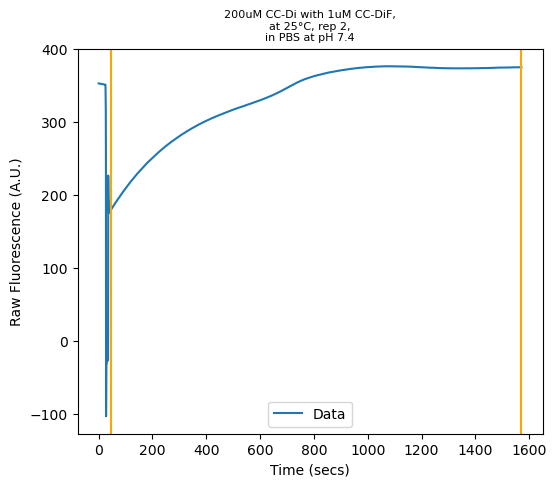

/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_91000/2042243895.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


Saving plot to: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2.png


<Figure size 640x480 with 0 Axes>

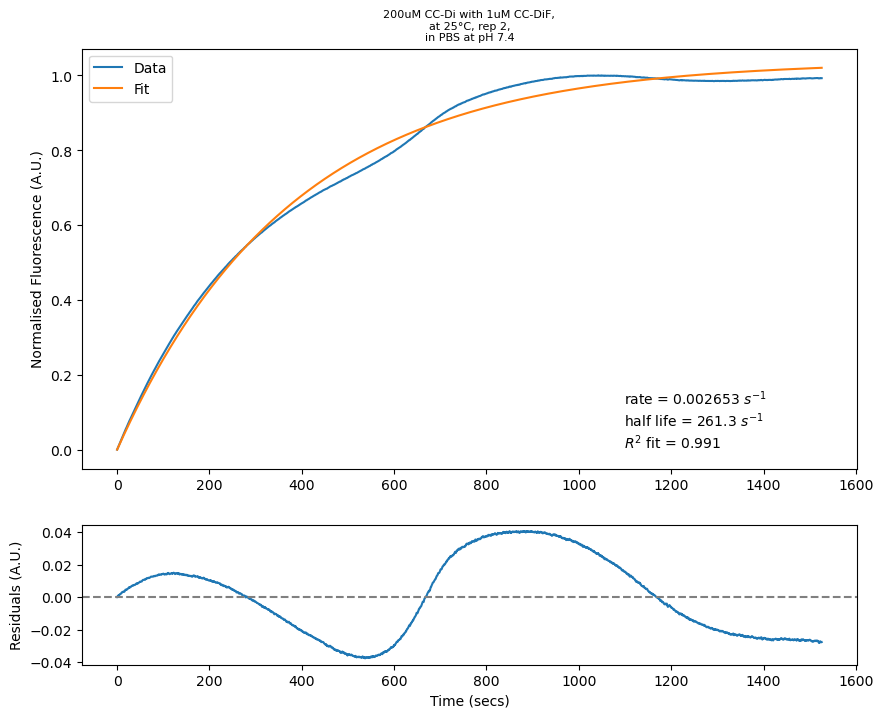

In [106]:
df, data= file_to_data(txt_files[0],
            trim=(88,-1))

In [107]:
master_df_constant_CCDi = df.copy()

master_dict_constant_CCDi = [data.copy()]

In [108]:
txt_files

['./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_5uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_5uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_5uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_10uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_10uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_10uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_20uM_25degC_rep2.txt',
 './CCDi

The concentration of CC-Di was: 200
The concentration of labelled CC-Di was: 1
The temperature was: 25°C
The is replicate number: 3
Reading file at: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep3.txt
Saving plot to: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep3_trimmed_data.png


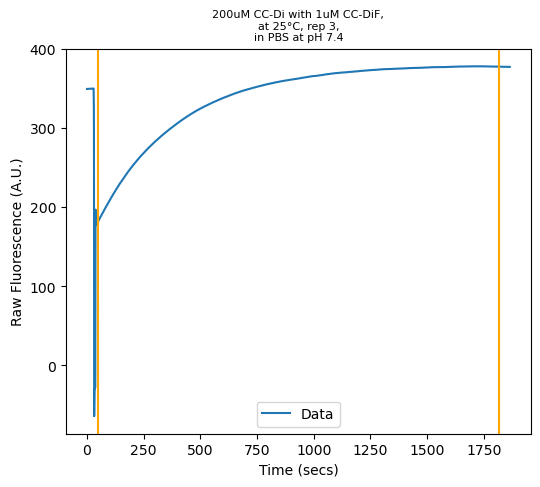

Saving plot to: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep3.png


/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_91000/2042243895.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

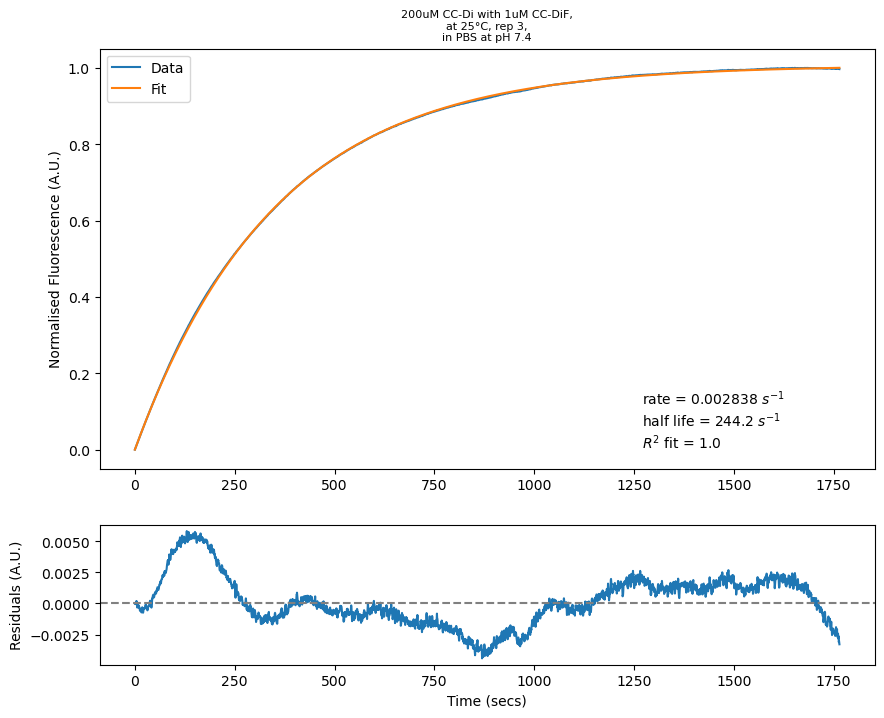

In [136]:
df, data= file_to_data(txt_files[1],
            trim=(100,-100))

In [137]:
master_df_constant_CCDi = pd.concat([master_df_constant_CCDi,df],ignore_index=True)

master_dict_constant_CCDi.append(data)

In [138]:
master_df_constant_CCDi.to_excel('master_df_constant_CCDi.xlsx')

In [139]:
df_rates_constant_CCDi=pd.DataFrame(master_dict_constant_CCDi)

In [140]:
df_rates_constant_CCDi.to_excel('df_rates_constant_CCDi.xlsx')

In [141]:
df_rates_constant_CCDi

,temp,concDi,concDiF,rep,filepath,rate,halflife,r2,rmv from start,rmv from end,figpath
0,25,200,1,2,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002653,261.255894,0.991459,88,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
1,25,200,20,1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.003290,210.700178,0.997526,105,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
2,25,200,20,3,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.003201,216.569902,0.999974,70,-150,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
3,25,200,20,2,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002848,243.404706,0.987246,75,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
4,25,200,10,2,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002980,232.574690,0.999943,88,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
5,25,200,10,3,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002911,238.089544,0.999927,80,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
6,25,200,10,1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002507,276.488302,0.996912,100,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
7,25,200,2,1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002442,283.864497,0.993172,85,-4500,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
8,25,200,2,3,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002745,252.506268,0.999489,56,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
9,25,200,2,2,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002663,260.316502,0.993643,113,-500,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...


In [142]:
folder_path = "./CCDi_data/Arhenius_files/"
txt_files = find_txt_files(folder_path)

In [143]:
txt_files

['./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_40degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_40degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_40degC_rep1.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_37degC_rep1.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_37degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_37degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_28degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_28degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_28degC_rep1.txt']

The concentration of CC-Di was: 20
The concentration of labelled CC-Di was: 2
The temperature was: 32°C
The is replicate number: 1
Reading file at: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1.txt
Saving plot to: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1_trimmed_data.png


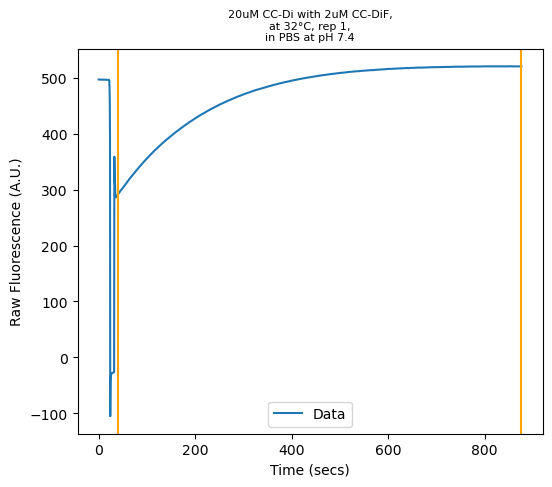

Saving plot to: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1.png


/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_91000/2042243895.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

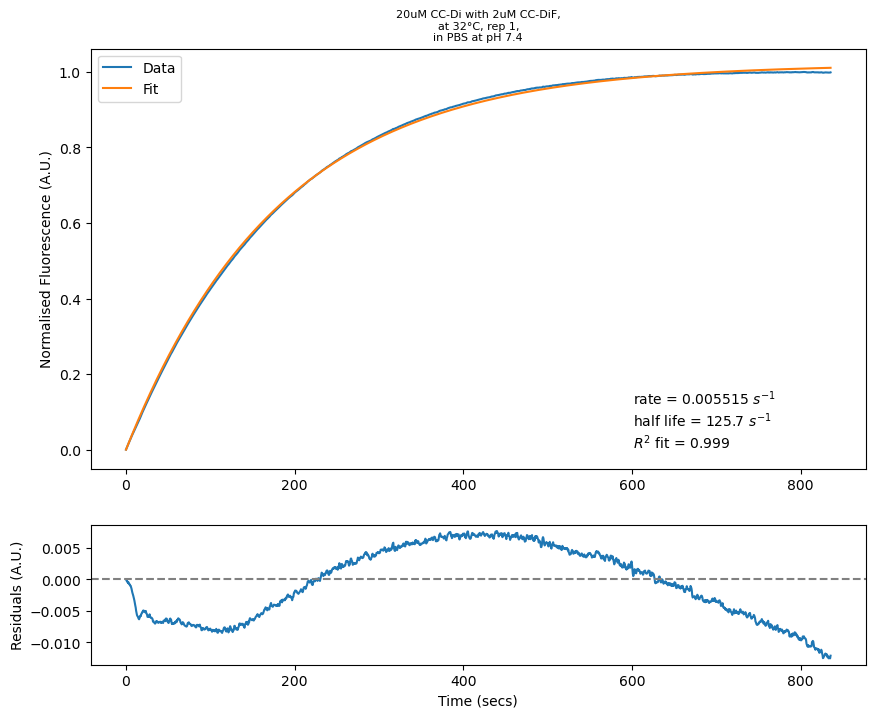

In [144]:
df, data= file_to_data(txt_files[0],
            trim=(80,-1))

In [145]:
master_df_varTemp = df.copy()

master_dict_varTemp = [data.copy()]

The concentration of CC-Di was: 20
The concentration of labelled CC-Di was: 2
The temperature was: 32°C
The is replicate number: 2
Reading file at: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep2.txt
Saving plot to: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep2_trimmed_data.png


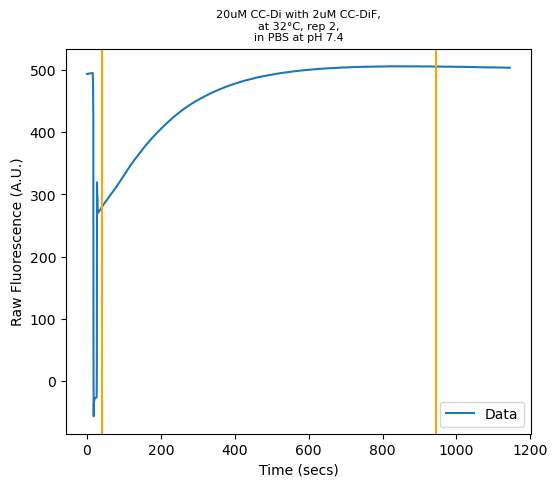

Saving plot to: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep2.png


/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_91000/2042243895.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

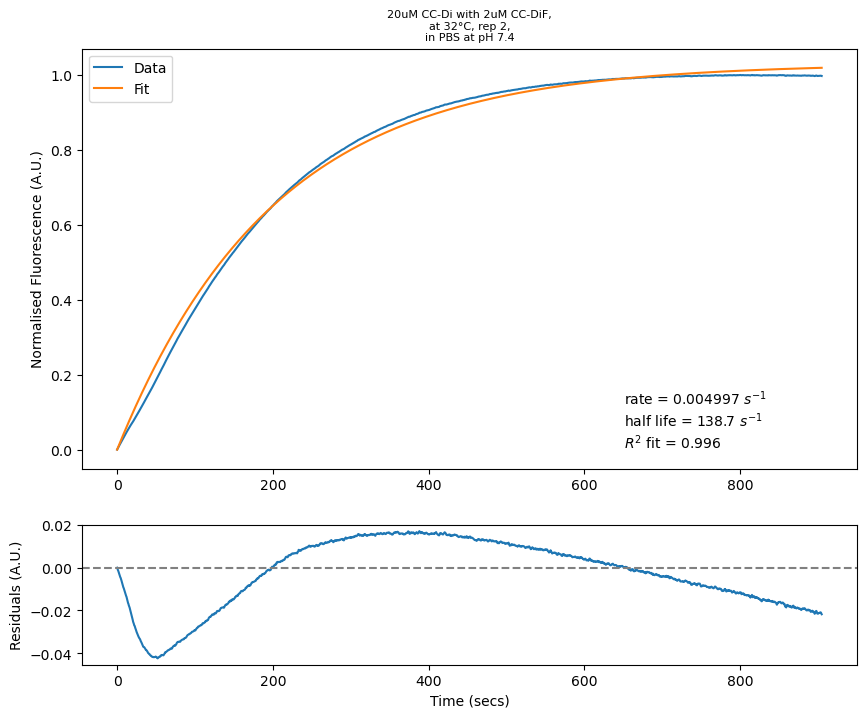

In [166]:
df, data= file_to_data(txt_files[1],
            trim=(80,-400))

In [167]:
master_df_varTemp = pd.concat([master_df_varTemp,df],ignore_index=True)

master_dict_varTemp.append(data)

In [599]:
df_rates_varTemp=pd.DataFrame(master_dict_varTemp)

In [601]:
master_df_varTemp = pd.concat([master_df_varTemp,
                               master_df[master_df['concDi']==20]],
                              ignore_index=True)
df_rates_varTemp = pd.concat([df_rates_varTemp,
                               df_rates[df_rates['concDi']==20]],
                              ignore_index=True)

In [602]:
master_df_varTemp.to_excel('master_df_varTemp.xlsx')
df_rates_varTemp.to_excel('df_rates_varTemp.xlsx')